In [1]:
"""
The goal of this assignment is to predict GPS coordinates from image features using k-Nearest Neighbors.
Specifically, have featurized 28616 geo-tagged images taken in Spain split into training and test sets (27.6k and 1k).

The assignment walks students through:
    * visualizing the data
    * implementing and evaluating a kNN regression model
    * analyzing model performance as a function of dataset size
    * comparing kNN against linear regression

Images were filtered from Mousselly-Sergieh et al. 2014 (https://dl.acm.org/doi/10.1145/2557642.2563673)
and scraped from Flickr in 2024. The image features were extracted using CLIP ViT-L/14@336px (https://openai.com/clip/).
"""

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


In [2]:
def plot_data(train_feats, train_labels):
    """
    Input:
        train_feats: Training set image features
        train_labels: Training set GPS (lat, lon)

    Output:
        Displays plot of image locations, and first two PCA dimensions vs longitude
    """
    # Plot image locations (use marker='.' for better visibility)
    plt.scatter(train_labels[:, 1], train_labels[:, 0], marker=".")
    plt.title('Image Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    # Run PCA on training_feats
    ##### TODO(a): Your Code Here #####
    transformed_feats = StandardScaler().fit_transform(train_feats)
    transformed_feats = PCA(n_components=2).fit_transform(transformed_feats)

    # Plot images by first two PCA dimensions (use marker='.' for better visibility)
    plt.scatter(transformed_feats[:, 0],     # Select first column
                transformed_feats[:, 1],     # Select second column
                c=train_labels[:, 1],
                marker='.')
    plt.colorbar(label='Longitude')
    plt.title('Image Features by Longitude after PCA')
    plt.show()

In [3]:
def grid_search(train_features, train_labels, test_features, test_labels, is_weighted=False, verbose=True):
    """
    Input:
        train_features: Training set image features
        train_labels: Training set GPS (lat, lon) coords
        test_features: Test set image features
        test_labels: Test set GPS (lat, lon) coords
        is_weighted: Weight prediction by distances in feature space

    Output:
        Prints mean displacement error as a function of k
        Plots mean displacement error vs k

    Returns:
        Minimum mean displacement error
    """
    # Evaluate mean displacement error (in miles) of kNN regression for different values of k
    # Technically we are working with spherical coordinates and should be using spherical distances, but within a small
    # A region like Spain we can get away with treating the coordinates as cartesian coordinates.
    knn = NearestNeighbors(n_neighbors=100).fit(train_features)

    if verbose:
        print(f'Running grid search for k (is_weighted={is_weighted})')

    ks = list(range(1, 11)) + [20, 30, 40, 50, 100]
    mean_errors = []
    for k in ks:
        distances, indices = knn.kneighbors(test_features, n_neighbors=k)

        errors = []
        for i, nearest in enumerate(indices):
            # Evaluate mean displacement error in miles for each test image
            # Assume 1 degree latitude is 69 miles and 1 degree longitude is 52 miles
            y = test_labels[i]

            

            ##### TODO(d): Your Code Here #####
            if is_weighted:
                mean_train = np.average(train_labels[nearest], axis = 0, weights=1/distances[i] + 10**(-8))
                e = np.sqrt(((y[0] - mean_train[0])*69)**2 + ((y[1] - mean_train[1])*52)**2)
            else:
                mean_train = train_labels[nearest].mean(axis = 0)
                e = np.sqrt(((y[0] - mean_train[0])*69)**2 + ((y[1] - mean_train[1])*52)**2)
            errors.append(e)
        
        e = np.mean(np.array(errors))
        mean_errors.append(e)
        if verbose:
            print(f'{k}-NN mean displacement error (miles): {e:.1f}')

    # Plot error vs k for k Nearest Neighbors
    if verbose:
        plt.plot(ks, mean_errors)
        plt.xlabel('k')
        plt.ylabel('Mean Displacement Error (miles)')
        plt.title('Mean Displacement Error (miles) vs. k in kNN')
        plt.show()

    return min(mean_errors)

Predicting GPS from CLIP image features

Loading Data
Train Data Count: 27616


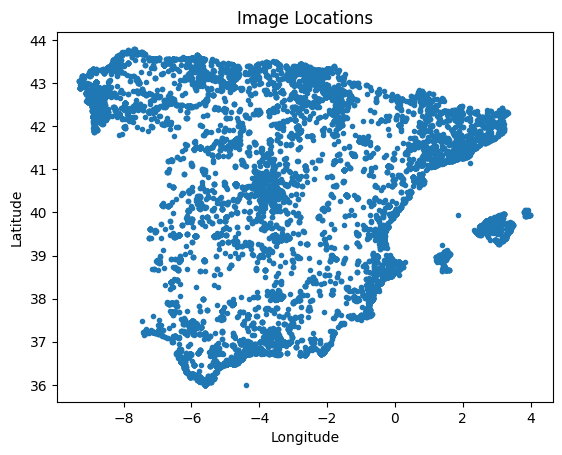

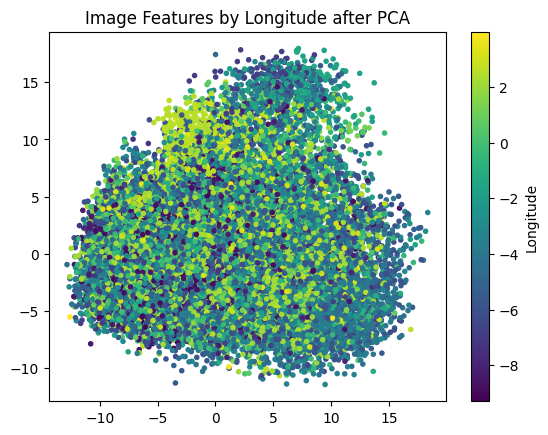

In [4]:
print("Predicting GPS from CLIP image features\n")

# Import Data
print("Loading Data")
data = np.load('im2spain_data.npz')

train_features = data['train_features']  # [N_train, dim] array
test_features = data['test_features']    # [N_test, dim] array
train_labels = data['train_labels']      # [N_train, 2] array of (lat, lon) coords
test_labels = data['test_labels']        # [N_test, 2] array of (lat, lon) coords
train_files = data['train_files']        # [N_train] array of strings
test_files = data['test_files']          # [N_test] array of strings

# Data Information
print('Train Data Count:', train_features.shape[0])

# Part A: Feature and label visualization (modify plot_data method)
plot_data(train_features, train_labels)


In [5]:
# Part C: Find the 5 nearest neighbors of test image 53633239060.jpg
knn = NearestNeighbors(n_neighbors=3).fit(train_features)
# Use knn to get the k nearest neighbors of the features of image 53633239060.jpg
##### TODO(c): Your Code Here #####
indexes = knn.kneighbors(test_features[np.where(test_files == '53633239060.jpg')[0][0]].reshape(1,-1), return_distance=False)[0]
files = train_files[indexes]
files

array(['31870484468.jpg', '4554482343.jpg', '53643099910.jpg'],
      dtype='<U15')

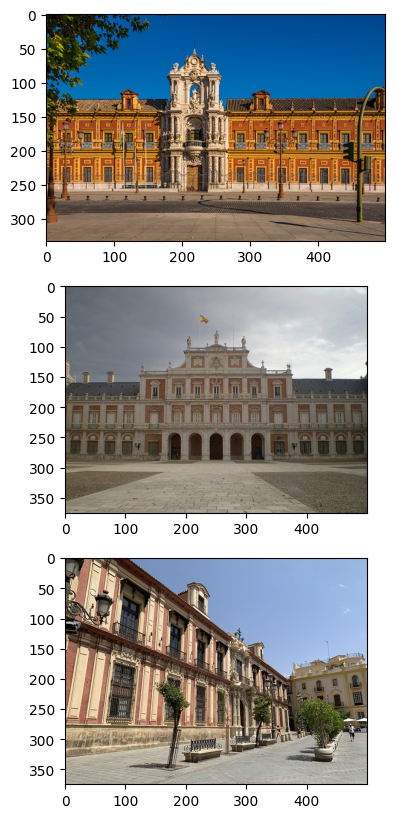

In [6]:
fig, ax = plt.subplots(nrows=3, figsize = (13,10), dpi = 100)
for i in range(len(files)):
    img = plt.imread(f'im2spain_images/{files[i]}')
    ax[i].imshow(img)

In [7]:
print('Default Image:', test_labels[np.where(test_files == '53633239060.jpg')[0][0]])
print()
print('Closest images distance:\n', train_labels[indexes])
print()
print('Off by:\n', train_labels[indexes] - test_labels[np.where(test_files == '53633239060.jpg')[0][0]])

Default Image: [37.380455 -5.993931]

Closest images distance:
 [[37.380424 -5.994328]
 [40.036533 -3.609201]
 [37.38637  -5.992387]]

Off by:
 [[-3.0517578e-05 -3.9720535e-04]
 [ 2.6560783e+00  2.3847299e+00]
 [ 5.9165955e-03  1.5439987e-03]]


In [8]:
# Part D: establish a naive baseline of predicting the mean of the training set
##### TODO(d): Your Code Here #####
#grid_search(train_features, train_labels, test_features, test_labels)
ans = []
mean_train = train_labels.mean(axis = 0)
for test in test_labels:
    ans.append(np.sqrt(((test[0] - mean_train[0])*69)**2 + ((test[1] - mean_train[1])*52)**2))

np.mean(ans)

209.86265574922942

Running grid search for k (is_weighted=False)
1-NN mean displacement error (miles): 137.3
2-NN mean displacement error (miles): 133.0
3-NN mean displacement error (miles): 132.4
4-NN mean displacement error (miles): 133.5
5-NN mean displacement error (miles): 133.1
6-NN mean displacement error (miles): 135.1
7-NN mean displacement error (miles): 136.2
8-NN mean displacement error (miles): 136.6
9-NN mean displacement error (miles): 136.8
10-NN mean displacement error (miles): 138.1
20-NN mean displacement error (miles): 145.1
30-NN mean displacement error (miles): 149.5
40-NN mean displacement error (miles): 152.3
50-NN mean displacement error (miles): 154.6
100-NN mean displacement error (miles): 161.6


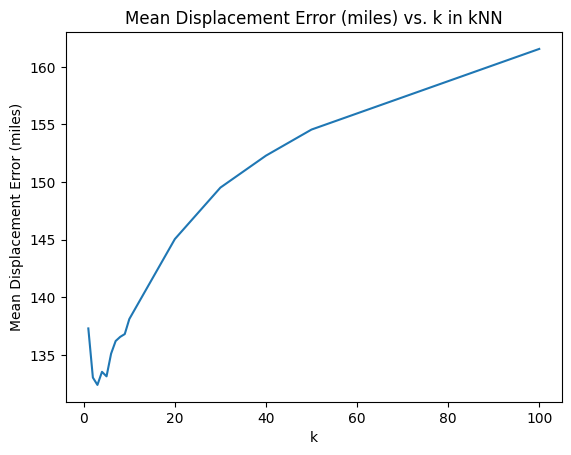

Running grid search for k (is_weighted=True)
1-NN mean displacement error (miles): 137.3
2-NN mean displacement error (miles): 131.9
3-NN mean displacement error (miles): 131.0
4-NN mean displacement error (miles): 131.9
5-NN mean displacement error (miles): 131.6
6-NN mean displacement error (miles): 133.5
7-NN mean displacement error (miles): 134.7
8-NN mean displacement error (miles): 135.1
9-NN mean displacement error (miles): 135.4
10-NN mean displacement error (miles): 136.6
20-NN mean displacement error (miles): 143.5
30-NN mean displacement error (miles): 148.0
40-NN mean displacement error (miles): 150.8
50-NN mean displacement error (miles): 153.1
100-NN mean displacement error (miles): 160.3


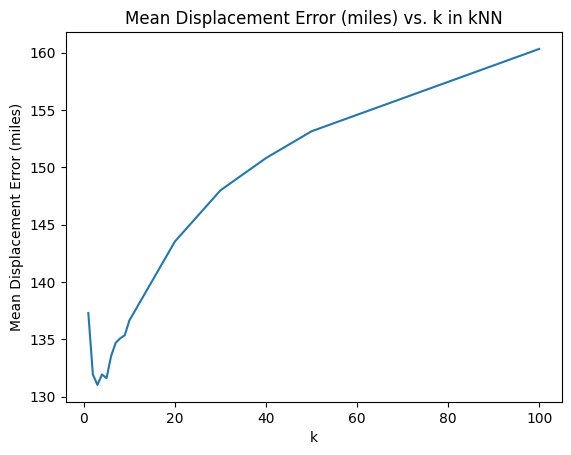

131.02949226096484

In [9]:
# Part E: complete grid_search to find the best value of k
grid_search(train_features, train_labels, test_features, test_labels)

# Parts G: rerun grid search after modifications to find the best value of k
grid_search(train_features, train_labels, test_features, test_labels, is_weighted=True)


Training set ratio: 0.1 (2761)
Linear Regression mean displacement error (miles): 184.7
kNN mean displacement error (miles): 166.8

Training set ratio: 0.2 (5523)
Linear Regression mean displacement error (miles): 166.9
kNN mean displacement error (miles): 156.6

Training set ratio: 0.30000000000000004 (8284)
Linear Regression mean displacement error (miles): 161.7
kNN mean displacement error (miles): 150.5

Training set ratio: 0.4 (11046)
Linear Regression mean displacement error (miles): 159.2
kNN mean displacement error (miles): 145.5

Training set ratio: 0.5 (13808)
Linear Regression mean displacement error (miles): 158.9
kNN mean displacement error (miles): 142.6

Training set ratio: 0.6000000000000001 (16569)
Linear Regression mean displacement error (miles): 158.2
kNN mean displacement error (miles): 139.4

Training set ratio: 0.7000000000000001 (19331)
Linear Regression mean displacement error (miles): 157.4
kNN mean displacement error (miles): 137.7

Training set ratio: 0.8 (

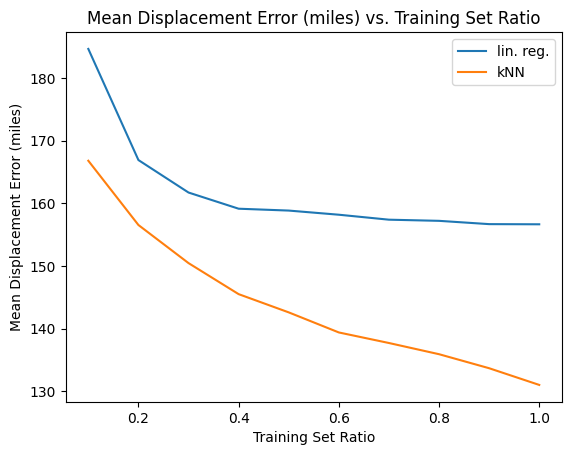

In [10]:
# Part H: compare to linear regression for different # of training points
mean_errors_lin = []
mean_errors_nn = []
ratios = np.arange(0.1, 1.1, 0.1)
for r in ratios:
    num_samples = int(r * len(train_features))
    ##### TODO(h): Your Code Here #####
    X = train_features[:num_samples]
    y = train_labels[:num_samples]
    e_nn = grid_search(X, y, test_features, test_labels, is_weighted=True, verbose=False)

    lr = LinearRegression()
    lr.fit(X,y)
    preds = lr.predict(test_features)
    
    e_lin = []
    for i in range(len(test_labels)):
        e_lin.append(np.sqrt(((test_labels[i][0] - preds[i][0])*69)**2 + ((test_labels[i][1] - preds[i][1])*52)**2))
    e_lin = np.mean(e_lin)
    

    mean_errors_lin.append(e_lin)
    mean_errors_nn.append(e_nn)

    print(f'\nTraining set ratio: {r} ({num_samples})')
    print(f'Linear Regression mean displacement error (miles): {e_lin:.1f}')
    print(f'kNN mean displacement error (miles): {e_nn:.1f}')

# Plot error vs training set size
plt.plot(ratios, mean_errors_lin, label='lin. reg.')
plt.plot(ratios, mean_errors_nn, label='kNN')
plt.xlabel('Training Set Ratio')
plt.ylabel('Mean Displacement Error (miles)')
plt.title('Mean Displacement Error (miles) vs. Training Set Ratio')
plt.legend()
plt.show()